In [1]:
import numpy as np
from utils.database_repository import DataRepository
from utils.objects import *
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import time
from datetime import datetime
import inspect
from utils.constants import *
from datetime import datetime
import math
import statistics
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs


In [2]:
# %store data

In [3]:
%store -r

In [4]:
# repository = DataRepository()

# data = repository.get_experiments(
#         duts,
#         oses,
#         test_cases,
#         profilers,
#         dut_version,
#         min_temp,
#         max_temp,
#         min_battery,
#         max_battery,
#         duration,
#         between,
#         env,
#         language,
#         special_between
#     )

# repository.close()


np.percentile(arr, 50)
statistics.median(items)

In [5]:
# for d in duts:
#             for o in os:
#                 for t in test_cases:
#                     for p in profilers:
#                         if o in special_between and p in special_between[o]:
#                             version = special_between[o][p]
#                         else:
#                             version = dut_version[d][o]
                        
#                         exp = data[d][o][t][p]
                        
#                         k = exp.k
#                         points_to_look_back = exp.points_to_look_back
                        
#                         outliers = find_outliers(exp["experiment"], k, points_to_look_back, p, 1, 0, 0, 1, False, False, min_sampels=4, show_graphs=False)
                        
#                         for e in exp["experiment"]:
#                             if e.id in outliers:
#                                 e.is_outlier = True
#                             else:
#                                 e.is_outlier = False
                        
                        

### Configuration

The configuration defines under what circumstances the experiment was executed under.

In [6]:
# CONFIGURATION
min_temp = 0
max_temp = 200

min_battery = 40
max_battery = 80

between = 0
duration = 1

special_between = {
    WINDOWS_OS : {
        CLAMP : 1
    }
}

language = "CSharp"

env = "PROD"

limit = 200

### Operating System

Here the different operation systems used in the experiments are defined

In [7]:
## OS
oses = [
    WINDOWS_OS,
    LINUX_OS
]

short_os = {
    WINDOWS_OS : "win",
    LINUX_OS : "lin"
}

### Test Cases

Here the different test cases executed during the experiments are defined

In [8]:
## Test cases
test_cases = [
    IDLE_CASE,
    # DINING_PHILOSOPHERS,
    BINARY_TREE,
    # REVERSE_COMPLEMENT
    FANNKUCH_REDUX,
    NBODY,
    FASTA
]

short_test_case = {
    IDLE_CASE : "idle",
    DINING_PHILOSOPHERS : "din",
    BINARY_TREE : "bin",
    REVERSE_COMPLEMENT : "rev",
    FANNKUCH_REDUX : "fann",
    NBODY : "nbody",
    FASTA : "fasta"
}

### Profilers

Here the different profilers used to measure the energy consumption of the test cases are defined

In [9]:
## Profilers
profilers = [
    INTEL_POWER_GADGET,
    RAPL,
    HARDWARE_MONITOR,
    CLAMP,
    E3
]

short_profilers = {
    INTEL_POWER_GADGET : "IPG",
    RAPL : "RA",
    HARDWARE_MONITOR : "HWM",
    E3 : "E3",
    CLAMP : "CL"
}

### DUT

Here the different Devices Under Tests (DUT) are defined

In [10]:
## DUT
duts = [
    SURFACE_4_PRO,
    SURFACE_BOOK,
    POWER_KOMPLETT
]

short_duts = {
    SURFACE_4_PRO : "pro",
    SURFACE_BOOK : "book",
    POWER_KOMPLETT : "pow",
}

dut_version = {
    SURFACE_BOOK : {
            WINDOWS_OS : 6,
            LINUX_OS : 3
        },
    SURFACE_4_PRO : {
        WINDOWS_OS : 12,
        LINUX_OS : 2,
    },
    POWER_KOMPLETT : {
        WINDOWS_OS : 8,
        LINUX_OS : 1,
    }
}

### Types

Here the different types of energy measurements are defined

In [11]:
## Types
comparison_types = [PACKAGE_TOTAL, DRAM_TOTAL,CORE_TOTAL]


In [12]:
def find_outliers(experiments, k, points_to_look_back, profiler, y_max, y_min, x_min, x_max, use_x_lim, use_y_lim, min_sampels=4, show_graphs=False):
    exp_data_points = []
    k = 1

    for e in experiments:
        if profiler == INTEL_POWER_GADGET:
            power = e.CumulativeProcessorEnergyInJoules
        elif profiler == HARDWARE_MONITOR:
            power = e.cpuPowerPacketTotalJ
        elif profiler == RAPL:
            power = e.CoreStopInJoules - e.CoreStartInJoules
        elif profiler == CLAMP:
            power = e.TrueRMS
        else:
            raise Exception("profiler not implemented") ## ipg CumulativeProcessorEnergyInJoules, TrueRMS, x.CoreStopInJoules - x.CoreStartInJoules
        
        exp_data_points.append(ExpDataPoint(
            e.id, power, e.runs, e.duration
        ))
    
    # if show_graphs:
    #     plt.scatter(*zip(*(x.get_tuple() for x in exp_data_points)))
    #     plt.show()
    
    for p1 in exp_data_points:
        dists = []
        for p2 in exp_data_points:
            if p1.exp_id == p2.exp_id:
                dists.append(math.inf)
            else:
                dists.append(math.dist(p1.get_tuple(), p2.get_tuple()))
        sorted_by_second = sorted(dists, key=lambda tup: tup)
        p1.set_distance_to_k(sorted_by_second[k])
    
    exp_data_points = sorted(exp_data_points, key=lambda tup: tup.dist)
    
    for i in range(len(exp_data_points)):
        exp_data_points[i].set_id(i)

    if show_graphs:
        plt.scatter(*zip(*((x.id, x.dist) for x in exp_data_points)))

        plt.show()
    
    eps = exp_data_points[-points_to_look_back].dist
    min_sampels = 4
    
    data_arr = np.array([x.get_tuple() for x in exp_data_points])
    
    dbscan = DBSCAN(eps = eps, min_samples = min_sampels)
    pred = dbscan.fit_predict(data_arr)
    anom_index = np.where(pred == -1)
    values = data_arr[anom_index]

    if show_graphs:
        plt.scatter(data_arr[:,0], data_arr[:,1])
        plt.scatter(values[:,0], values[:,1], color='r')
        if use_x_lim:
            plt.xlim(x_min, x_max)
        if use_y_lim:
            plt.ylim(y_min,y_max)
        plt.show()

    points_to_remove = []

    for v in values:
        for e in exp_data_points:
            tup = (v[0], v[1])
            
            if tup == e.get_tuple():
                points_to_remove.append(e)
                break

    print(f"{len(points_to_remove)} points were removed")
                
    # for p in points_to_remove:
    #     print(f"{p.exp_id} - {p.get_tuple()}")
    
    return [x.exp_id for x in points_to_remove]
    

In [13]:
# def get_dynamic_energy(
#     d, o, p, energy_type, duration, energy_consumption, dynamic_energy, per_unit=1000
# ):
#     dynamic_energy_index = dynamic_energy[d][o][p]

#     dynamic_energy_consumption = dynamic_energy_index[energy_type]
#     dynamic_duration = dynamic_energy_index["duration"]

#     if dynamic_duration == 0 or duration == 0:
#         return 0

#     dynamic_energy_per_unit = (per_unit / dynamic_duration) * dynamic_energy_consumption
#     energy_per_unit = (per_unit / duration) * energy_consumption

#     return energy_per_unit - dynamic_energy_per_unit

In [14]:
def default_func(exp, value):
    return True


def get_consumption(
    d,
    o,
    p,
    t,
    value_type,
    func_parameter,
    data,
    dynamic_energy,
    func=default_func,
    get_dynamic=True,
):
    try:
        data_points = data[d][o][t][p]["experiment"].experiments
    except Exception as e:
        return 0, 0, 0, 0, 0, 0, 0, 0,0, 0, 0

    # duration = [
    #     exp.duration / exp.runs for exp in data_points if func(exp, func_parameter)
    # ]

    duration_list = [x.duration for x in data_points if func(x, func_parameter)]
    runs_list = [x.runs for x in data_points if func(x, func_parameter)]

    if len(duration_list) > 0:
        avg_dur = sum(duration_list) / len(duration_list)
    else:
        avg_dur = 0
    
    if len(runs_list) > 0:
        avg_run = sum(runs_list) / len(runs_list)
    else:
        avg_run = 0

    length = len(duration_list)

    if value_type == PACKAGE_TOTAL:
        if p == INTEL_POWER_GADGET:
            values = [
                (x.CumulativeProcessorEnergyInJoules, x.duration)
                for x in data_points
                if func(x, func_parameter)
            ]
        elif p == CLAMP:
            values = [(x.TrueRMS, x.duration) for x in data_points]
        elif p == HARDWARE_MONITOR:
            values = [
                (x.cpuPowerPacketTotalJ, x.duration)
                for x in data_points
                if func(x, func_parameter)
            ]
        elif p == RAPL:
            values = [
                (x.PSysStopInJoules - x.PSysStartInJoules, x.duration) for x in data_points if func(x, func_parameter)
            ]
        else:
            raise Exception(f"{p} not implemented")
    elif value_type == DRAM_TOTAL:
        if p == INTEL_POWER_GADGET:
            values = [
                (x.CumulativeDramEnergyInJoules, x.duration)
                for x in data_points
                if func(x, func_parameter)
            ]
        elif p == CLAMP:
            values = [(0, 0) for x in data_points]
        elif p == HARDWARE_MONITOR:
            values = [
                (x.cpuPowerMemoryTotalJ, x.duration)
                for x in data_points
                if func(x, func_parameter)
            ]
        elif p == RAPL:
            values = [
                (x.DramStopInJoules - x.DramStartInJoules, x.duration) for x in data_points if func(x, func_parameter)
            ]
        else:
            raise Exception(f"{p} not implemented")
    elif value_type == CORE_TOTAL:
        if p == INTEL_POWER_GADGET:
            values = [
                (x.CumulativeProcessorEnergyInJoules, x.duration)
                for x in data_points
                if func(x, func_parameter)
            ]
        elif p == CLAMP:
            values = [
                (x.TrueRMS, x.duration) for x in data_points if func(x, func_parameter)
            ]
        elif p == HARDWARE_MONITOR:
            values = [
                (x.cpuPowerCoresTotalJ, x.duration)
                for x in data_points
                if func(x, func_parameter)
            ]
        elif p == RAPL:
            values = [
                (x.CoreStopInJoules - x.CoreStartInJoules, x.duration) for x in data_points if func(x, func_parameter)
            ]
        else:
            raise Exception(f"{p} not implemented")
    else:
        raise Exception(f"{value_type} not implmeneted")

    if get_dynamic:
        if length == 0:
            return 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
        
        only_values = [x[0] / avg_run for x in values]
        avg_value = sum(only_values) / len(only_values)
        
        dyn_val = []
        
        for v in only_values:
            dyn = get_dynamic_energy(d, o, p, value_type, v, dynamic_energy, avg_run, avg_dur)
            dyn_val.append(dyn)

        return (
            length,
            sum(dyn_val) / len(dyn_val),
            np.std(dyn_val),
            min(dyn_val),
            max(dyn_val),
            avg_dur,
            avg_run,
            0,
            np.percentile(dyn_val, 25),
            np.percentile(dyn_val, 75),
            statistics.median(dyn_val)
        )
    else:
        only_values = [x[0] / avg_run for x in values]
        
        avg_value = sum(only_values) / len(only_values)
        
        value_for_one_sec = avg_value * (1000 / (avg_dur / avg_run))
        
        return (
            length,
            avg_value,
            np.std(only_values),
            min(only_values),
            max(only_values),
            avg_dur,
            avg_run,
            value_for_one_sec,
            np.percentile(only_values, 25),
            np.percentile(only_values, 75),
            statistics.median(only_values)
        )

In [15]:
def initialize_dynamic_energy(data, used_profilers = profilers):
    dynamic_energy = {}
    for d in duts:
        dynamic_energy[d] = {}
        for o in oses:
            dynamic_energy[d][o] = {}
            for p in used_profilers:
                dynamic_energy[d][o][p] = {}
                for types in comparison_types:
                    t = IDLE_CASE
                    
                    count, average, _, min_value, max_value, avg_dur, avg_run, _, _, _, _ = get_consumption(
                        d, o, p, t, types, "", data, dynamic_energy, get_dynamic=False)
                    dynamic_energy[d][o][p][types] = average
                    dynamic_energy[d][o][p]["avg_dur"] = avg_dur
                    dynamic_energy[d][o][p]["avg_run"] = avg_run
    return dynamic_energy

In [16]:
def is_correct_first_profiler(exp, value):
    return exp.first_profiler == value

def plot_first_profiler_comparison(comparison_type, data, dynamic_energy, xlabel, ylabel, label, ylim_max=100):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])

    x = []
    y = []
    e = []

    i = 0

    for d in duts:
        for t in test_cases:
            if t != IDLE_CASE:
                for o in oses:
                    for p in profilers:
                        for first_profiler in profilers:
                            length, average, std, min_value, max_value, _, _, _, _, _, _ = get_consumption(d, o, p, t, comparison_type, first_profiler, data, dynamic_energy, func=is_correct_first_profiler)
                            
                            if not min_value == 0 and not max_value == 0:
                                x.append(f"{short_os[o]} {short_duts[d]} {short_profilers[p]} {short_test_case[t]}")
                                y.append(average)
                                e.append(std)
                                
                                # print(f"{i} - {first_profiler}, {p}, {d}, {o}, {t} - sum of {length} ({min_value} - {max_value})")
                                # print(f"{i} - {d}, {t}, {o}, {p}, {first_profiler} - sum of {length} ({min_value} - {max_value})")
                                i += 1

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(label)
    ax = plt.gca()
    ax.tick_params(axis='x', labelrotation = 90)
    plt.errorbar(x, y, e, linestyle='None', marker='.')
    plt.ylim(0,ylim_max)
    plt.show()

In [17]:
def plot_comparison(comparison_type, data, dynamic_energy, xlabel, ylabel, label, ylim_max=100, get_dynamic=True, used_test_cases = test_cases, include_idle = False, plot_graph=True):
    
    if plot_graph:
        fig = plt.figure()
        ax = fig.add_axes([0,0,1,1])

    x = []
    y = []
    e = []
    
    perc25 = []
    perc75 = []
    low_whiskey = []
    high_whiskey = []
    median = []
    names = []


    i = 0

    for t in used_test_cases:
        if include_idle or t != IDLE_CASE:
            for d in duts:
                for o in oses:
                    for p in profilers:
                        if (p == CLAMP and d == POWER_KOMPLETT) or p != CLAMP:
                            length, average, std, min_value, max_value, _, _, val_for_one_sec, p25, p75, m = get_consumption(d, o, p, t, comparison_type, "", data, dynamic_energy, get_dynamic=get_dynamic)
                            
                            if length > 0:
                                if plot_graph:
                                    x.append(f"{short_os[o]} {short_duts[d]} {short_profilers[p]} {short_test_case[t]}")
                                    e.append(std)
                                    if get_dynamic:
                                        y.append(average)
                                    else:
                                        y.append(val_for_one_sec)
                                
                                perc25.append(p25)
                                perc75.append(p75)
                                low_whiskey.append(min_value)
                                high_whiskey.append(max_value)
                                median.append(m)
                                
                                used_dut_name = "workstation" if d == POWER_KOMPLETT else d
                                
                                
                                if p == CLAMP:
                                    names.append(f"{used_dut_name} - {p} ({short_os[o]})")
                                else:
                                    names.append(f"{used_dut_name} - {p}")
                                # names.append(f"{}")
                                # names.append(f"{short_os[o]} {short_duts[d]} {short_profilers[p]} {short_test_case[t]}")
                                
                                i += 1

    if plot_graph:
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(label)
        plt.errorbar(x, y, e, linestyle='None', marker='.')
        ax.tick_params(axis='x', labelrotation = 90)
        plt.ylim(0,ylim_max)
        
        plt.show()
    
    return perc25, perc75, low_whiskey, high_whiskey, median, names

In [18]:
def plot_iterations(comparison_type, get_next_value, is_correct_value, xlabel, ylabel, label, data, dynamic_energy, used_duts = duts, used_test_cases = test_cases, plot_graph=True):
    if plot_graph:
        fig = plt.figure()
        ax = fig.add_axes([0,0,1,1])
    
    x_lines = []
    y_lines = []
    name_lines = []
    
    print(used_test_cases)
    for d in used_duts:
        for t in used_test_cases:
            if t != IDLE_CASE:
                for o in oses:
                    for p in profilers:
                        if (p == CLAMP and d == POWER_KOMPLETT) or p != CLAMP:
                            x1 = []
                            y1 = []
                            avg_len = []
                            for i in get_next_value():
                                length, average, _, min_value, max_value, _, _, _, _, _, _ = get_consumption(d, o, p, t, comparison_type, i, data, dynamic_energy, func=is_correct_value)
                                
                                if length > 0:
                                    avg_len.append(length)
                                    if isinstance(i, tuple) or isinstance(i, list):
                                        x1.append(i[0])
                                    else:
                                        x1.append(i)
                                    y1.append(average)
                            if len(x1) > 0:
                                print(f"{d} - {t} - {o} - {p} - avg {sum(avg_len) / len(avg_len)} ({min(avg_len)}, {max(avg_len)})")
                                if plot_graph:
                                    plt.plot(x1, y1, label = f"{short_os[o]} {short_duts[d]} {short_profilers[p]} {short_test_case[t]}")
                                x_lines.append(x1)
                                y_lines.append(y1)
                                
                                used_dut_name = "workstation" if d == POWER_KOMPLETT else d
                                if p == CLAMP:
                                    name_lines.append(f"{used_dut_name} - {p} ({short_os[o]})")
                                else:
                                    name_lines.append(f"{used_dut_name} - {p}")
                                
    if plot_graph:
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(label)
        plt.legend()
        plt.show()
    return x_lines, y_lines, name_lines

### Datainitialization

The data for the experiments will be fetched from the database and stored in a dictionary, in the order as can be seen below:

```python
data[current_dut][current_os][current_test_case][current_profiler]
```

In [19]:
# exp = data[SURFACE_4_PRO][LINUX_OS][BINARY_TREE][RAPL]["experiment"].experiments[0]
# inspect.getmembers(exp, lambda a:not(inspect.isroutine(a)))

### Dynamic Energy

Next up, the dynamic energy will be calculated. This will be the average energy consumption of the idle case.

In [20]:
dynamic_energy = initialize_dynamic_energy(data)
dynamic_energy.keys()

dict_keys(['Surface4Pro', 'SurfaceBook', 'PowerKomplett'])

### Dynamic Energy Example

An example of how the dynamic energy consumption is calculated can be seen below.

In [21]:
def get_dynamic_energy(d, o, p, energy_type, energy_consumption, dynamic_energy, avg_run, avg_dur, per_unit=1000):
    dynamic_energy_index = dynamic_energy[d][o][p]

    dynamic_energy_consumption = dynamic_energy_index[energy_type]
    dyn_avg_dur = dynamic_energy_index["avg_dur"]
    dyn_avg_run = dynamic_energy_index["avg_run"]
    
    if dyn_avg_dur == 0 or dyn_avg_run == 0:
        return 0
    
    dynamic_energy_per_unit = dynamic_energy_consumption * (per_unit / (dyn_avg_dur / dyn_avg_run))
    energy_per_unit = energy_consumption * (per_unit / (avg_dur / avg_run))
    
    return energy_per_unit - dynamic_energy_per_unit 

In [22]:
dynamic_energy_dut = SURFACE_4_PRO
dynamic_energy_os = WINDOWS_OS
dynamic_energy_profiler = INTEL_POWER_GADGET
dynamic_energy_test_case = NBODY
dynamic_energy_type = CORE_TOTAL

In [23]:
_, energy_consumption, _, _, _, avg_dur, avg_run, energy_consumption_per_sec, perc25, perc75, _ = get_consumption(dynamic_energy_dut, 
                                                            dynamic_energy_os, 
                                                            dynamic_energy_profiler, 
                                                            dynamic_energy_test_case, 
                                                            dynamic_energy_type, "", 
                                                            data,
                                                            dynamic_energy, 
                                                            get_dynamic=False)

dynamic_energy_consumption = get_dynamic_energy(dynamic_energy_dut, 
                                                dynamic_energy_os, 
                                                dynamic_energy_profiler, 
                                                dynamic_energy_type, 
                                                energy_consumption,
                                                dynamic_energy, 
                                                avg_run, 
                                                avg_dur)
# dynamic_energy_consumption = get_dynamic_energy(d, v, o, p, dynamic_energy_type, duration, energy_consumption, per_unit=0.5716669904816651)



energy_consumption, energy_consumption_per_sec, dynamic_energy_consumption, 

(0.011286532015858873, 10.609059452768342, 9.013808087628382)

In [24]:
# data_to_inspect = data[power_komplett][windows_os][idle_case][intel_power_gadget]["experiment"].experiments[0].start_battery.data
# inspect.getmembers(data_to_inspect, lambda a:not(inspect.isroutine(a)))

### Intel Power Gadget

- CumulativeDramEnergyInJoules
- CumulativeGtEnergyInJoules
- CumulativeIaEnergyInJoules
- CumulativeProcessorEnergyInJoules

### Clamp

- TrueRMS
- ACRMSRAW

idle -  true: 3651, acr: 3612
fans - 600 - 700

### OpenHardwareMonitor

- cpuPowerPacketTotalJ
- cpuPowerCoresTotalJ
- cpuPowerMemoryTotalJ
- cpuPowerPacketAverageJ
- cpuPowerCoresAverageJ
- cpuPowerMemoryAverageJ

### Dynamic energy consumption

A graph comparing the package measuring made by different measuring instruments on the different DUTs

In [25]:
# plot_comparison(PACKAGE_TOTAL, data, dynamic_energy, "Package total DUT", "joules in a second", "average package energy consumption in joules for DUTs")


### Dynamic energy consumption

A graph comparing the dram measuring made by different measuring instruments on the different DUTs

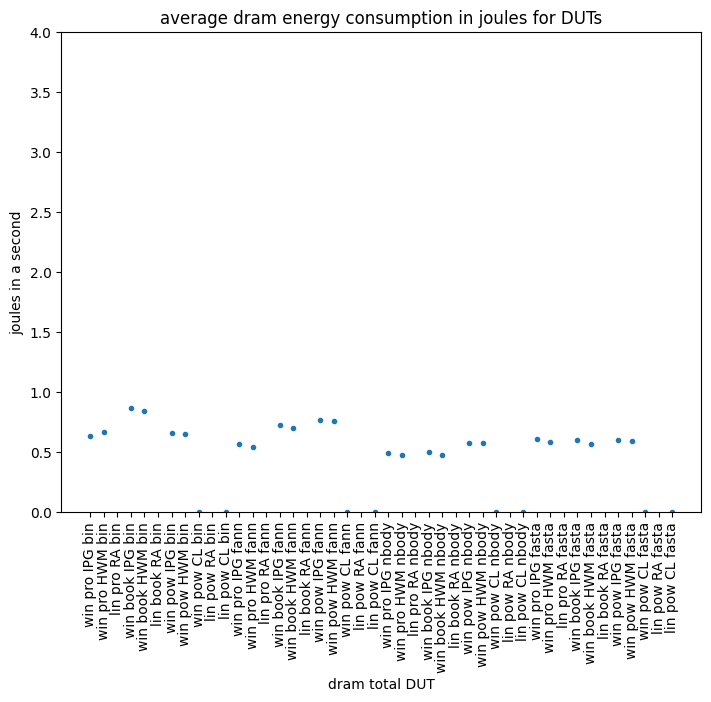

([0.0008813876871049779,
  0.000980200513310084,
  0.2867472410421629,
  0.0024510883201131484,
  0.002310985906808003,
  0.13658890033709867,
  0.00036892227998690507,
  0.0003689393752983137,
  0.0,
  1.106533800384058,
  0.0,
  0.00019847333646277556,
  0.00019296810834176683,
  0.05702848079122692,
  0.0002904343010784056,
  0.00028047266839679384,
  0.027818692250563146,
  0.000500631629427352,
  0.0004838796681976955,
  0.0,
  0.45406402327383005,
  0.0,
  0.0005272880862004947,
  0.0005048767312041305,
  0.09140231110464898,
  0.0008780522488387444,
  0.0006414349795769133,
  0.038333111279869415,
  0.0004342594598978944,
  0.0004320474023551338,
  0.0,
  0.3557175889002173,
  0.0,
  0.00044561327298938205,
  0.0004237085938944941,
  0.06851095965394915,
  0.000677622978090714,
  0.0006360610672991036,
  0.029865011032601373,
  0.00018338407672179442,
  0.0001820137713413591,
  0.0,
  0.26190456556896474,
  0.0],
 [0.0011152844149888328,
  0.0011400609302572341,
  0.857209047402

In [26]:
plot_comparison(DRAM_TOTAL,
                data,
                dynamic_energy,
                "dram total DUT",
                "joules in a second",
                "average dram energy consumption in joules for DUTs",
                get_dynamic=False,
                ylim_max=4)

### Dynamic energy consumption

A graph comparing the core measuring made by different measuring instruments on the different DUTs

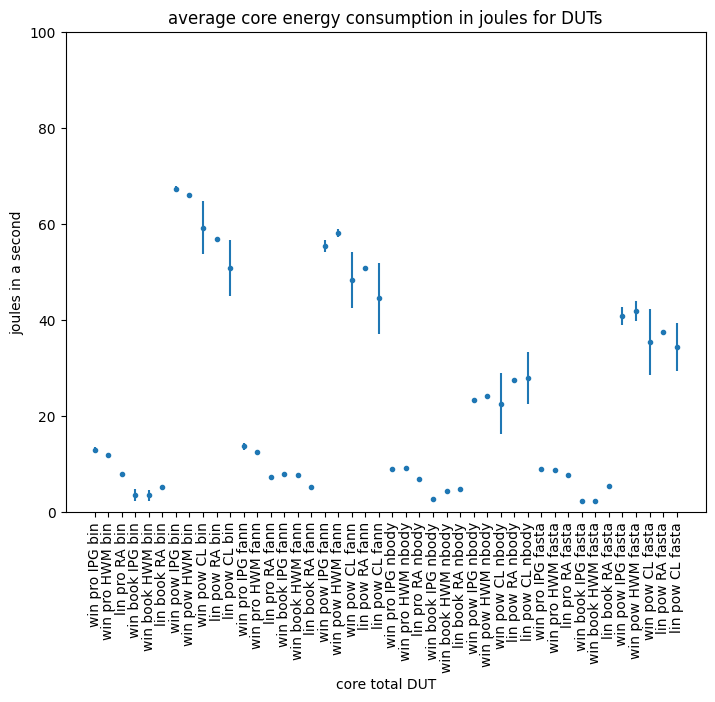

([12.552756896896696,
  11.82501211230277,
  8.008843738477655,
  2.665594787259187,
  2.521514632098685,
  4.965006129287774,
  66.88112214478394,
  65.82913886644438,
  56.36316375457969,
  56.74991796973922,
  51.41174505704115,
  13.019465314894402,
  12.352712729272964,
  7.257120679428706,
  7.80691501946041,
  7.587621390330239,
  5.1600721625483015,
  54.76765389869192,
  57.610076378536085,
  45.29290238883078,
  50.74228280513373,
  45.07112286091041,
  8.91318643349108,
  9.07827049534706,
  6.876633207489784,
  2.59526403324083,
  4.347554313087066,
  4.808150705371661,
  23.248886074194413,
  24.1019688419309,
  18.53530410106578,
  27.459952420093884,
  28.965611421272452,
  8.750756694422252,
  8.701466912366223,
  7.802741895149747,
  2.0363559891122045,
  2.098323329445337,
  5.261938343869186,
  40.00929819885625,
  41.10844859371965,
  31.09456906666264,
  37.41134321072847,
  34.37882489587339],
 [13.50256201500023,
  12.164381684498439,
  8.054927834406875,
  4.358

In [27]:
plot_comparison(CORE_TOTAL, data, dynamic_energy, "core total DUT", "joules in a second", "average core energy consumption in joules for DUTs", ylim_max=100, get_dynamic=True)


In [28]:
# plot_comparison(CORE_TOTAL, data, dynamic_energy, "core total DUT", "joules in a second", "average core energy consumption in joules for DUTs", ylim_max=10, get_dynamic=False)


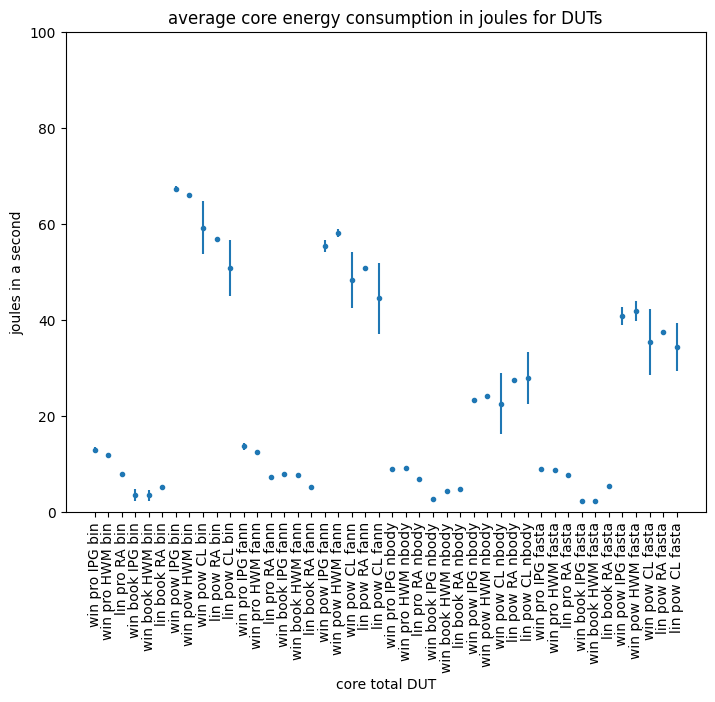

([12.552756896896696,
  11.82501211230277,
  8.008843738477655,
  2.665594787259187,
  2.521514632098685,
  4.965006129287774,
  66.88112214478394,
  65.82913886644438,
  56.36316375457969,
  56.74991796973922,
  51.41174505704115,
  13.019465314894402,
  12.352712729272964,
  7.257120679428706,
  7.80691501946041,
  7.587621390330239,
  5.1600721625483015,
  54.76765389869192,
  57.610076378536085,
  45.29290238883078,
  50.74228280513373,
  45.07112286091041,
  8.91318643349108,
  9.07827049534706,
  6.876633207489784,
  2.59526403324083,
  4.347554313087066,
  4.808150705371661,
  23.248886074194413,
  24.1019688419309,
  18.53530410106578,
  27.459952420093884,
  28.965611421272452,
  8.750756694422252,
  8.701466912366223,
  7.802741895149747,
  2.0363559891122045,
  2.098323329445337,
  5.261938343869186,
  40.00929819885625,
  41.10844859371965,
  31.09456906666264,
  37.41134321072847,
  34.37882489587339],
 [13.50256201500023,
  12.164381684498439,
  8.054927834406875,
  4.358

In [29]:
# used_test_cases = [IDLE_CASE, FASTA]

plot_comparison(CORE_TOTAL, data, dynamic_energy, "core total DUT", "joules in a second", "average core energy consumption in joules for DUTs", ylim_max=100, get_dynamic=True, include_idle=False)
# plot_comparison(CORE_TOTAL, data, dynamic_energy, "core total DUT", "joules in a second", "average core energy consumption in joules for DUTs", ylim_max=100)



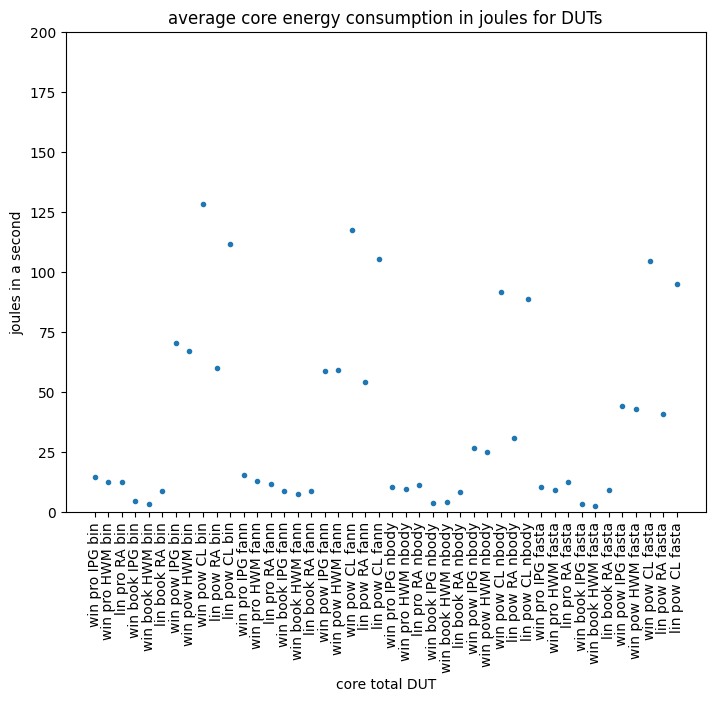

([0.0222461678921314,
  0.019259390905299493,
  0.04146019542261452,
  0.010721940168214202,
  0.00735839744325651,
  0.03621972266557198,
  0.04008022870671875,
  0.038610403383051106,
  0.07174850935400044,
  0.07283807423269553,
  0.13151672739531783,
  0.005568831286356673,
  0.004909489313421956,
  0.008031197727137852,
  0.0035388974695346855,
  0.0030887018092692706,
  0.007406602161443791,
  0.03817866351418866,
  0.03735505663106205,
  0.07464110981446342,
  0.030364329530938053,
  0.05866200361156766,
  0.011179484871296686,
  0.010117214755068661,
  0.012315706223382135,
  0.006304518048100112,
  0.005948692957397786,
  0.010238136455819363,
  0.019923577408239884,
  0.01885290251359385,
  0.06462174952198291,
  0.02362891414305251,
  0.06577256160562706,
  0.007613167050826272,
  0.006729217648639696,
  0.009604621405572198,
  0.003467197210824967,
  0.0024347088566849364,
  0.007683342406017356,
  0.013290350659894737,
  0.012937019166821585,
  0.03055799033069164,
  0.017

In [30]:
plot_comparison(CORE_TOTAL, data, dynamic_energy, "core total DUT", "joules in a second", "average core energy consumption in joules for DUTs", ylim_max=200, get_dynamic=False, include_idle=False)


In [31]:
# dynamic_energy_dut = SURFACE_4_PRO
# dynamic_energy_os = WINDOWS_OS
# dynamic_energy_profiler = INTEL_POWER_GADGET
# dynamic_energy_test_case = NBODY
# dynamic_energy_type = CORE_TOTAL

d = [x.cpuPowerCoresTotalJ for x in data[SURFACE_4_PRO][WINDOWS_OS][IDLE_CASE][HARDWARE_MONITOR]["experiment"].experiments]
dd = [x.cpuPowerCoresTotalJ for x in data[SURFACE_4_PRO][WINDOWS_OS][NBODY][HARDWARE_MONITOR]["experiment"].experiments]
# d = [x.CumulativeProcessorEnergyInJoules for x in data[POWER_KOMPLETT][LINUX_OS][FASTA][CLAMP]["experiment"].experiments] ACRMSRAW, cpuPowerCoresTotalJ

In [32]:
idle_per_sec = (sum(d) / len(d)) / 60
test_per_sec = (sum(dd) / len(dd)) / 60
# min(d) / 60, max(d) / 60, (sum(d) / len(d)) / 60, len(d)
idle_per_sec, test_per_sec, test_per_sec - idle_per_sec

(0.4751499180706542, 9.63935565022253, 9.164205732151876)

In [33]:
count,avg_value,std, min_value, max_value, avg_dur, avg_run, value_for_one_sec, perc25, prec75, med = get_consumption(
                                                            POWER_KOMPLETT,
                                                            LINUX_OS,
                                                            CLAMP,
                                                            FASTA,
                                                            CORE_TOTAL,
                                                            "",
                                                            data,
                                                            dynamic_energy,
                                                            get_dynamic=False,
                                                        )

count,avg_value,std, min_value, max_value, avg_dur, avg_run, value_for_one_sec , perc25, prec75, med


(120,
 0.03799538662314518,
 0.002003430089469504,
 0.03225563641422468,
 0.041522779985800284,
 60043.59166666667,
 150399.94166666668,
 95.17258666749449,
 0.038001424965397004,
 0.0387805192265376,
 0.0385529071577293)

In [34]:
sec_mult = 1000 / (avg_dur / avg_run) 
sec_mult

2504.8458543522065

In [35]:
avg_value * sec_mult

95.17258666749449

In [36]:
get_consumption(
    SURFACE_BOOK,
    WINDOWS_OS,
    INTEL_POWER_GADGET,
    IDLE_CASE,
    CORE_TOTAL,
    "",
    data,
    dynamic_energy,
    get_dynamic=False,
)

(124,
 30.011039749999984,
 4.066167863263209,
 17.797333,
 48.156372,
 60336.68548387097,
 2.0,
 0.9947858258810869,
 29.538864,
 31.291351375,
 30.3480225)

### How R3 validation affects the energy consumtion

A graph presenting the the effect of which profiler was the first one to execute upon startup

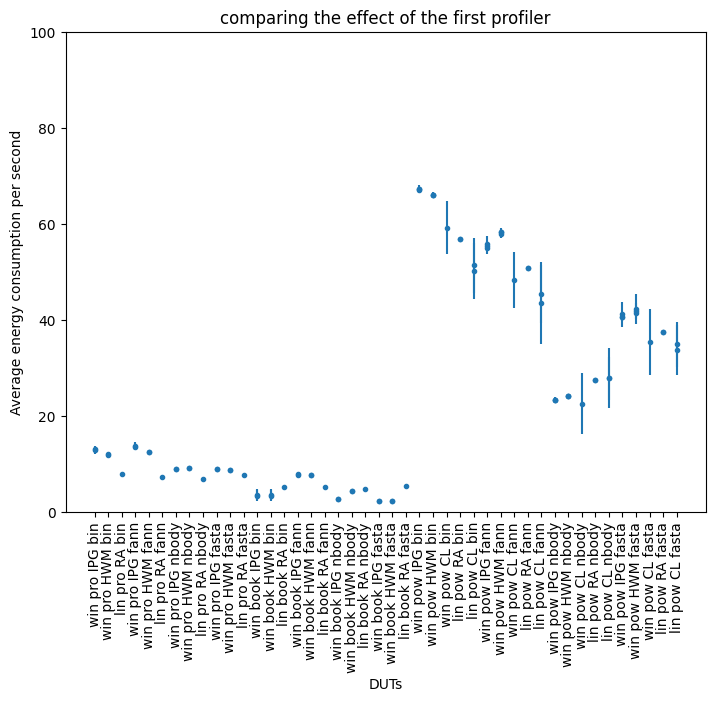

In [37]:
plot_first_profiler_comparison(CORE_TOTAL, data, dynamic_energy, "DUTs", "Average energy consumption per second", "comparing the effect of the first profiler", ylim_max=100)

In [38]:
def get_iteration():
    for i in range(30):
        yield i
        
def is_correct_iteration(exp, value):
    return exp.iteration == value

### How time passed since a restart effects energy consumptionn

A graph presenting the relationship between the iteration since a system restart, and how it affects the energy consumption

['Fasta']
PowerKomplett - Fasta - Win32NT - IntelPowerGadget - avg 4.344827586206897 (4, 5)
PowerKomplett - Fasta - Win32NT - HardwareMonitor - avg 4.344827586206897 (4, 5)
PowerKomplett - Fasta - Win32NT - Clamp - avg 4.0 (4, 4)
PowerKomplett - Fasta - Unix - RAPL - avg 4.0 (4, 4)
PowerKomplett - Fasta - Unix - Clamp - avg 4.0 (4, 4)


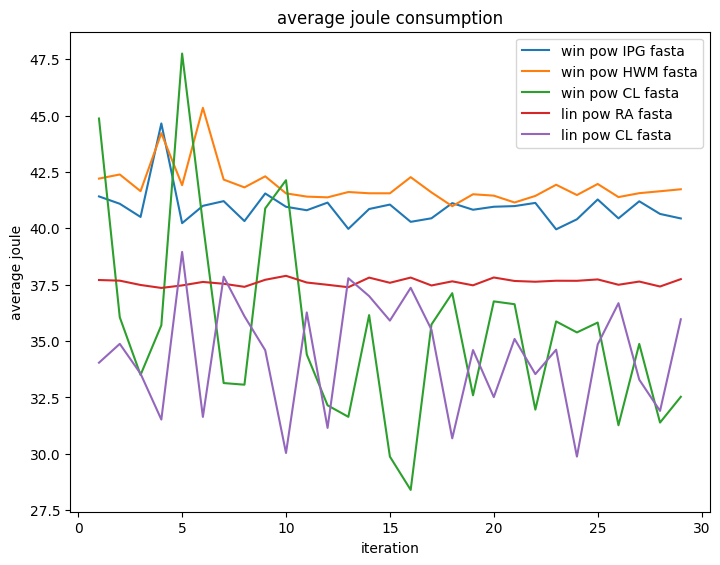

([[1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29],
  [1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29],
  [1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29],
  [1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29],
  [1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29]],
 [[41.41540929419298,
  

In [39]:
used_duts = [POWER_KOMPLETT]
used_test_cases = [FASTA]

plot_iterations(CORE_TOTAL,
                get_iteration,
                is_correct_iteration,
                "iteration",
                "average joule",
                "average joule consumption",
                data,
                dynamic_energy,
                used_duts=used_duts,
                used_test_cases = used_test_cases)

In [40]:
def get_buckets():
    min_bucket = 0
    max_bucket = 100
    bucket_size = 5

    last_value = 0

    for i in range(min_bucket + bucket_size, max_bucket + 1, bucket_size):
        # print(f"min: {last_value}, max: {i}, between: {((i - last_value) / 2) + last_value}")
        yield (last_value, i)
        last_value = i

def is_correct_temperature(exp, value):
    min_value = value[0]
    max_value = value[1]
    
    temp = [x.value for x in exp.start_temperature.data]
    
    avg_temp = sum(temp) / len(temp)
    
    return avg_temp > min_value and avg_temp < max_value

### Temperatures levels effect on energy consumption

A graph presenting the relationship between the temperature and energy consumption

['Fasta']
PowerKomplett - Fasta - Win32NT - IntelPowerGadget - avg 32.0 (1, 102)
PowerKomplett - Fasta - Win32NT - HardwareMonitor - avg 25.4 (1, 97)
PowerKomplett - Fasta - Win32NT - Clamp - avg 15.0 (1, 106)
PowerKomplett - Fasta - Unix - RAPL - avg 42.5 (7, 78)
PowerKomplett - Fasta - Unix - Clamp - avg 27.5 (1, 102)


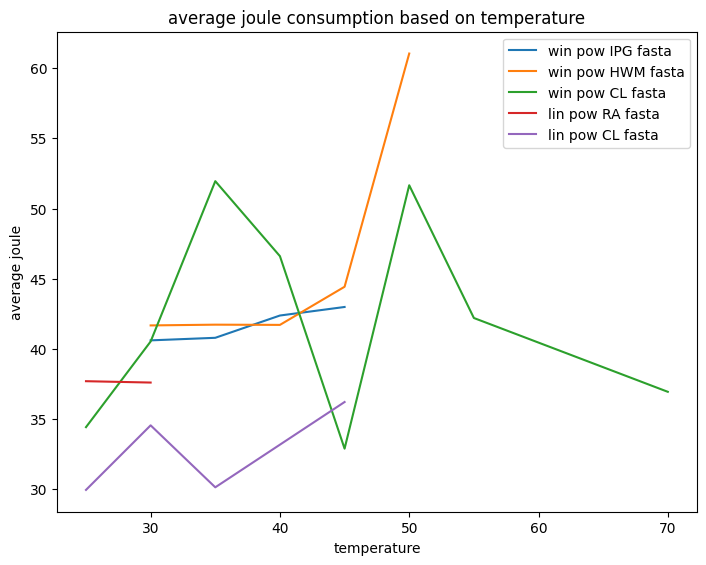

([[30, 35, 40, 45],
  [30, 35, 40, 45, 50],
  [25, 30, 35, 40, 45, 50, 55, 70],
  [25, 30],
  [25, 30, 35, 45]],
 [[40.606804832913625,
   40.78919353233987,
   42.37656118344358,
   42.98504952868071],
  [41.67144185598298,
   41.724817039613185,
   41.7091522832051,
   44.42564107419875,
   61.03847489893601],
  [34.42495941473996,
   40.52659314468388,
   51.94732545580568,
   46.604540406868864,
   32.89347324542739,
   51.65531888095896,
   42.20038481272823,
   36.94246821336914],
  [37.6984022699486, 37.60151854755857],
  [29.954597674402336,
   34.55371769472875,
   30.13948422580281,
   36.215331680081704]],
 ['workstation - IntelPowerGadget',
  'workstation - HardwareMonitor',
  'workstation - Clamp (win)',
  'workstation - RAPL',
  'workstation - Clamp (lin)'])

In [41]:
used_duts = [POWER_KOMPLETT]
used_test_cases = [FASTA]# test_cases

plot_iterations(CORE_TOTAL,
                get_buckets,
                is_correct_temperature,
                "temperature",
                "average joule",
                "average joule consumption based on temperature",
                data,
                dynamic_energy,
                used_duts=used_duts,
                used_test_cases=used_test_cases)

In [42]:
def is_correct_charge(exp, value):
    min_value = value[0]
    max_value = value[1]
    
    temp = [x.value for x in exp.start_battery.data]
    
    if len(temp) == 0:
        return False
    
    avg_temp = sum(temp) / len(temp)
    
    return avg_temp >= min_value and avg_temp < max_value

### Battery levels effect on energy consumption

A graph presenting the relationship between the battery level and energy consumption

['Fasta']
Surface4Pro - Fasta - Win32NT - IntelPowerGadget - avg 15.222222222222221 (6, 18)
Surface4Pro - Fasta - Win32NT - HardwareMonitor - avg 15.11111111111111 (6, 18)
Surface4Pro - Fasta - Unix - RAPL - avg 15.0 (4, 19)


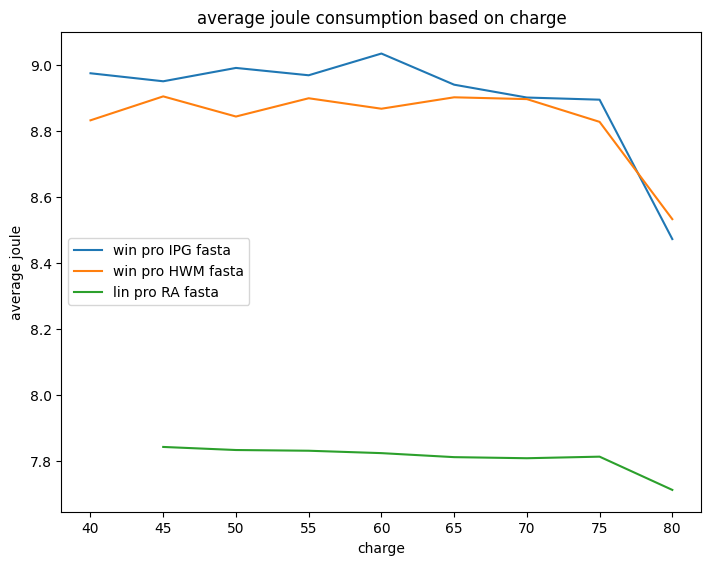

([[40, 45, 50, 55, 60, 65, 70, 75, 80],
  [40, 45, 50, 55, 60, 65, 70, 75, 80],
  [45, 50, 55, 60, 65, 70, 75, 80]],
 [[8.975047865768465,
   8.950758926889598,
   8.991234113011405,
   8.968971342691287,
   9.034853613125469,
   8.94042293437651,
   8.901485745215272,
   8.894967179861773,
   8.472381186789585],
  [8.832430390404687,
   8.904976816668006,
   8.843912493958358,
   8.899294479776824,
   8.867562777283572,
   8.902178256913285,
   8.896729321685262,
   8.8277387245177,
   8.53278431264586],
  [7.84220969415794,
   7.832879916181099,
   7.830719235402577,
   7.823463470794408,
   7.811290035981486,
   7.808005464496917,
   7.812761195003165,
   7.711976173538542]],
 ['Surface4Pro - IntelPowerGadget',
  'Surface4Pro - HardwareMonitor',
  'Surface4Pro - RAPL'])

In [43]:
used_duts = [SURFACE_4_PRO]
used_test_cases = [FASTA] #test_cases

plot_iterations(CORE_TOTAL,
                get_buckets,
                is_correct_charge,
                "charge",
                "average joule",
                "average joule consumption based on charge",
                data,
                dynamic_energy,
                used_duts=used_duts,
                used_test_cases=used_test_cases)


In [44]:
intel_power_gadget_data_point = data[SURFACE_4_PRO][WINDOWS_OS][BINARY_TREE][INTEL_POWER_GADGET]["experiment"].experiments[0].time_series.data_point[0]
inspect.getmembers(intel_power_gadget_data_point, lambda a:not(inspect.isroutine(a)))

[('CPUFrequency_0MHz', ' 3200'),
 ('CPUUtilization', '   71.000'),
 ('CumulativeDRAMEnergy_0Joules', '   0.113'),
 ('CumulativeDRAMEnergy_0mWh', '   0.031'),
 ('CumulativeGTEnergy_0Joules', '   0.026'),
 ('CumulativeGTEnergy_0mWh', '   0.007'),
 ('CumulativeIAEnergy_0Joules', '   1.830'),
 ('CumulativeIAEnergy_0mWh', '   0.508'),
 ('CumulativeProcessorEnergy_0Joules', '   2.177'),
 ('CumulativeProcessorEnergy_0mWh', '   0.605'),
 ('DRAMPower_0Watt', '   0.875'),
 ('ElapsedTimesec', '    0.129'),
 ('GTFrequencyMHz', 32),
 ('GTPower_0Watt', '   0.203'),
 ('GTUtilization', '   4.897'),
 ('IAPower_0Watt', '  14.175'),
 ('PackageHot_0', '  0'),
 ('PackagePL1_0Watt', '  25.000'),
 ('PackagePL2_0Watt', '  25.000'),
 ('PackagePL4_0Watt', '  46.000'),
 ('PackageTemperature_0C', ' 68'),
 ('PlatformPsysPL1_0Watt', '  45.000'),
 ('PlatformPsysPL2_0Watt', '  45.000'),
 ('ProcessorPower_0Watt', '  16.871'),
 ('RDTSC', ' 12063536978770'),
 ('SystemTime', '06:49:56:760'),
 ('__class__', utils.objects.

In [45]:
intel_power_gadget_data_point.SystemTime, intel_power_gadget_data_point.CumulativeProcessorEnergy_0Joules

('06:49:56:760', '   2.177')

In [46]:
hardware_monitor_data_point = data[SURFACE_4_PRO][LINUX_OS][BINARY_TREE][RAPL]["experiment"].experiments[0].time_series.data_point[:10]
inspect.getmembers(hardware_monitor_data_point, lambda a:not(inspect.isroutine(a)))

[('__add__', <method-wrapper '__add__' of list object at 0x000001189706F940>),
 ('__class__', list),
 ('__contains__',
  <method-wrapper '__contains__' of list object at 0x000001189706F940>),
 ('__delattr__',
  <method-wrapper '__delattr__' of list object at 0x000001189706F940>),
 ('__delitem__',
  <method-wrapper '__delitem__' of list object at 0x000001189706F940>),
 ('__doc__',
  'Built-in mutable sequence.\n\nIf no argument is given, the constructor creates a new empty list.\nThe argument must be an iterable if specified.'),
 ('__eq__', <method-wrapper '__eq__' of list object at 0x000001189706F940>),
 ('__ge__', <method-wrapper '__ge__' of list object at 0x000001189706F940>),
 ('__getattribute__',
  <method-wrapper '__getattribute__' of list object at 0x000001189706F940>),
 ('__gt__', <method-wrapper '__gt__' of list object at 0x000001189706F940>),
 ('__hash__', None),
 ('__iadd__',
  <method-wrapper '__iadd__' of list object at 0x000001189706F940>),
 ('__imul__',
  <method-wrapper 

In [47]:
# for i in [x for x in data[SURFACE_4_PRO][LINUX_OS][FANNKUCH_REDUX][RAPL]["experiment"].experiments[0].time_series.data_point[:10]]:
#     print(i.Core)
#     # print(i.CoreTotal)
#     print(i.PSys)
#     # print(i.PSysTotal)
#     print(i.PackageZero)
#     # print(i.PackageZeroTotal)
#     print("---")

In [48]:
# hardware_monitor_data_point.time, hardware_monitor_data_point.totalLoad

In [49]:
def plot_timestamp(timestamps, values):
    plt.plot(timestamps,values)
    plt.gcf().autofmt_xdate()
    plt.show()

In [50]:
data[SURFACE_4_PRO][LINUX_OS][BINARY_TREE][RAPL]["experiment"].experiments[0].time_series.data_point[0]

In [51]:
def get_time(x, p):
    if p == INTEL_POWER_GADGET:
        return datetime.strptime(x.SystemTime, "%H:%M:%S:%f")
    elif p == HARDWARE_MONITOR:
        return datetime.strptime(trim_date(x.time), "%Y-%m-%d %H:%M:%S.%f")
    elif p == RAPL:
        return datetime.strptime(trim_date(x.Time), "%Y-%m-%d %H:%M:%S.%f")
    else:
        raise Exception(f"{p} not implemented")

def get_value(x, p):
    if p == INTEL_POWER_GADGET:
        return float(x.ProcessorPower_0Watt)
    elif p == HARDWARE_MONITOR:
        return float(x.cpuPowerPacket)
    elif p == RAPL:
        return float(x.PackageZero)
    else:
        raise Exception(f"{p} not implemented")

def trim_date(date):
    date = date.replace("T", " ")
    date = date.replace("Z", " ")
    return date[:-3]        

def plot_test_case_time_series(d, o, t, p):
    data_points = data[d][o][t][p]["experiment"].experiments[0].time_series.data_point

    timestamps = [get_time(x, p) for x in data_points]
    
    values = []
    last_value = -1
    
    for x in data_points:
        new_value = get_value(x, p)
        
        # if p == RAPL:
        #     if last_value == -1:
        #         last_value = new_value
            
        #     values.append(new_value - last_value)
            
        #     last_value = new_value
        # else:
        values.append(new_value)
        
    
    
    
    # values = [get_value(x, p) for x in data_points]

    plot_timestamp(timestamps, values)
    print(values[:10])

In [52]:
# test_case = IDLE_CASE,
# test_case = BINARY_TREE,
# test_case = FANNKUCH_REDUX,
# test_case = NBODY
test_case = FASTA

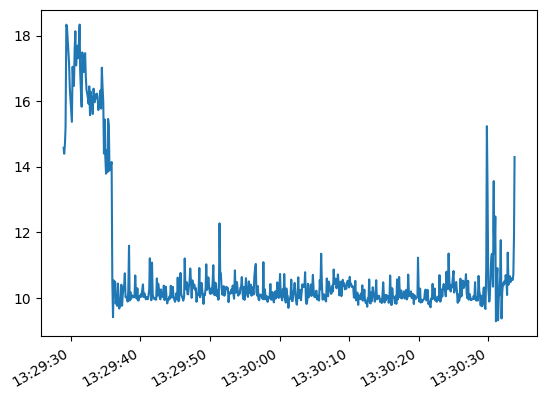

[14.575, 14.396, 14.701, 15.196, 18.332, 18.267, 17.863, 17.54, 17.157, 16.395]


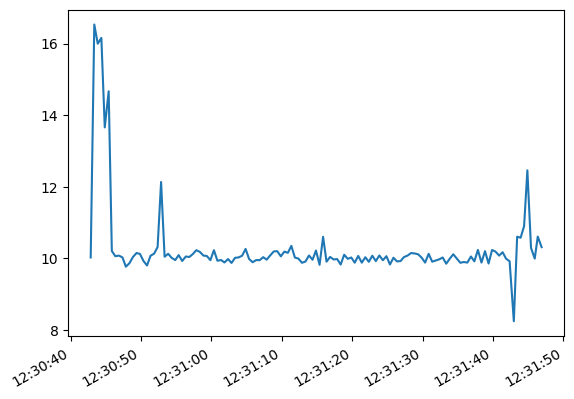

[10.025619, 16.533228, 15.997369, 16.159796, 13.659343, 14.668813, 10.206985, 10.060852, 10.0788, 10.02802]


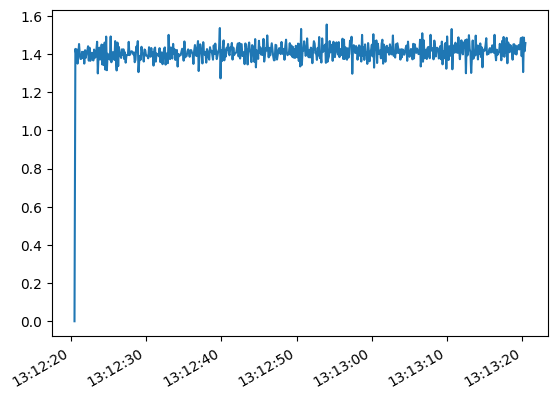

[0.0, 1.426632, 1.403988, 1.423703, 1.349483, 1.396237, 1.452084, 1.398129, 1.373714, 1.374814]


In [53]:
plot_test_case_time_series(SURFACE_4_PRO, WINDOWS_OS, test_case, INTEL_POWER_GADGET)
plot_test_case_time_series(SURFACE_4_PRO, WINDOWS_OS, test_case, HARDWARE_MONITOR)
plot_test_case_time_series(SURFACE_4_PRO, LINUX_OS, test_case, RAPL)

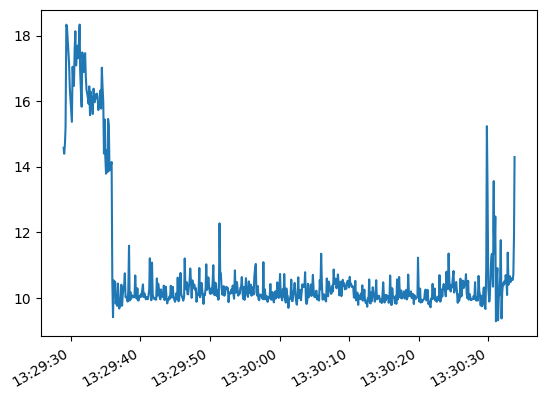

[14.575, 14.396, 14.701, 15.196, 18.332, 18.267, 17.863, 17.54, 17.157, 16.395]


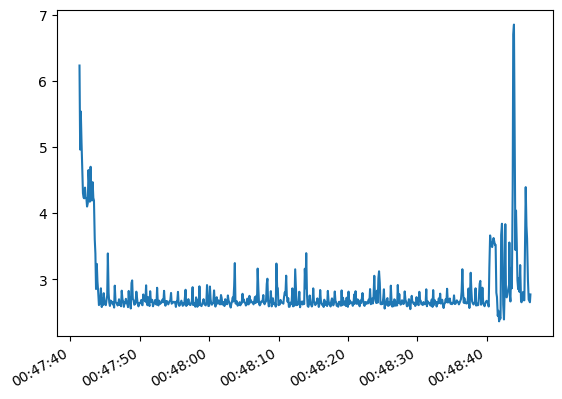

[6.233, 4.963, 5.539, 5.059, 4.726, 4.304, 4.238, 4.226, 4.388, 4.233]


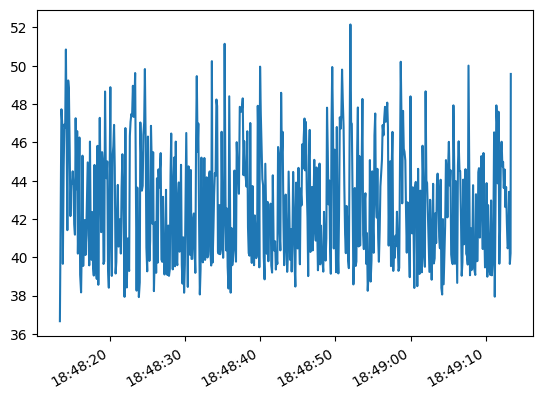

[36.666, 42.026, 47.722, 47.06, 39.66, 44.653, 46.934, 46.759, 50.842, 46.314]


In [54]:
plot_test_case_time_series(SURFACE_4_PRO, WINDOWS_OS, test_case, INTEL_POWER_GADGET)
plot_test_case_time_series(SURFACE_BOOK, WINDOWS_OS, test_case, INTEL_POWER_GADGET)
plot_test_case_time_series(POWER_KOMPLETT, WINDOWS_OS, test_case, INTEL_POWER_GADGET)

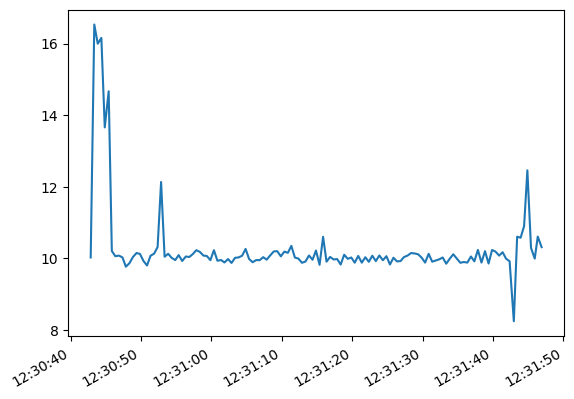

[10.025619, 16.533228, 15.997369, 16.159796, 13.659343, 14.668813, 10.206985, 10.060852, 10.0788, 10.02802]


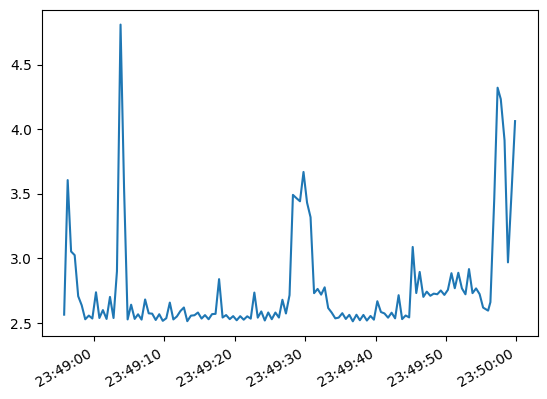

[2.5635817, 3.6057467, 3.0529032, 3.0243545, 2.7066133, 2.6359882, 2.527844, 2.5563436, 2.5336711, 2.736748]


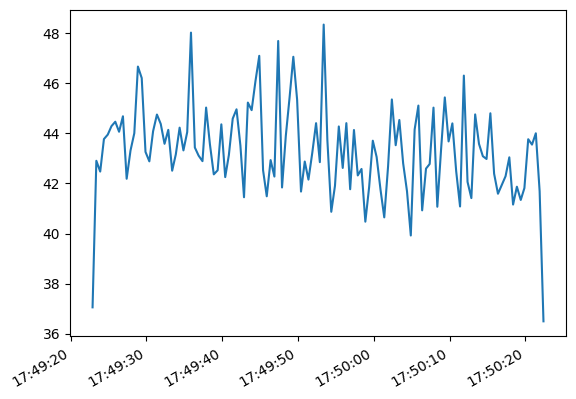

[37.052937, 42.904358, 42.472477, 43.770435, 43.94892, 44.286316, 44.463154, 44.062847, 44.67976, 42.185966]


In [55]:
plot_test_case_time_series(SURFACE_4_PRO, WINDOWS_OS, test_case, HARDWARE_MONITOR)
plot_test_case_time_series(SURFACE_BOOK, WINDOWS_OS, test_case, HARDWARE_MONITOR)
plot_test_case_time_series(POWER_KOMPLETT, WINDOWS_OS, test_case, HARDWARE_MONITOR)

In [56]:
exp = data[SURFACE_BOOK][WINDOWS_OS][FANNKUCH_REDUX][HARDWARE_MONITOR]["experiment"]

In [57]:
inspect.getmembers(exp.experiments[0], lambda a:not(inspect.isroutine(a)))

[('__class__', utils.objects.RawData),
 ('__delattr__',
  <method-wrapper '__delattr__' of RawData object at 0x00000119533DD390>),
 ('__dict__',
  {'cpuPowerPacketTotalJ': 541.1877729892731,
   'cpuPowerCoresTotalJ': 485.2658758163452,
   'cpuPowerMemoryTotalJ': 42.20328709483147,
   'cpuPowerPacketAverageJ': 4.509898108243942,
   'cpuPowerCoresAverageJ': 4.043882298469543,
   'cpuPowerMemoryAverageJ': 0.3516940591235956,
   'is_valid': True,
   'id': 5307,
   'start_time': datetime.datetime(2022, 11, 20, 3, 46, 3, 74330),
   'end_time': datetime.datetime(2022, 11, 20, 3, 47, 3, 196862),
   'runs': 152677,
   'iteration': 12,
   'first_profiler': 'IntelPowerGadget',
   'duration': 60122,
   'time_series': <utils.objects.TimeSeries at 0x119533dd4e0>,
   'has_time_series': True,
   'start_temperature': <utils.objects.Measurements at 0x119533dec50>,
   'stop_temperature': <utils.objects.Measurements at 0x119533deef0>,
   'start_battery': <utils.objects.Measurements at 0x119533df190>,
   '

In [58]:
# for o in os:
#     for d in duts:
#         for t in test_cases:
#             for p in profilers:
#                 print(f"{o} - {d} - {t} - {p}")

In [59]:
class ExpDataPoint(object):
    def __init__(self, exp_id, consumption, runs, duration):
        self.exp_id = exp_id
        self.x = consumption/ runs
        self.y = duration / runs
    
    def set_id(self, id):
        self.id = id
    
    def get_tuple(self):
        return (self.x, self.y)

    def set_distance_to_k(self, value):
        self.dist = value

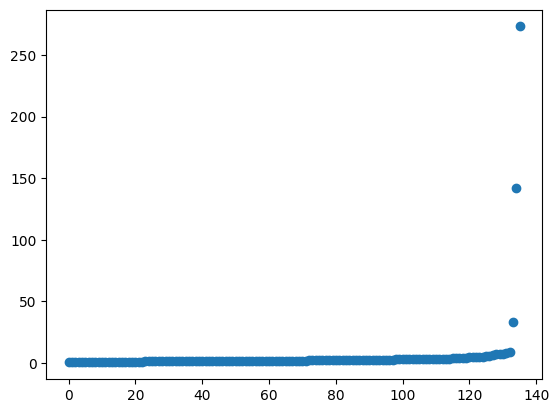

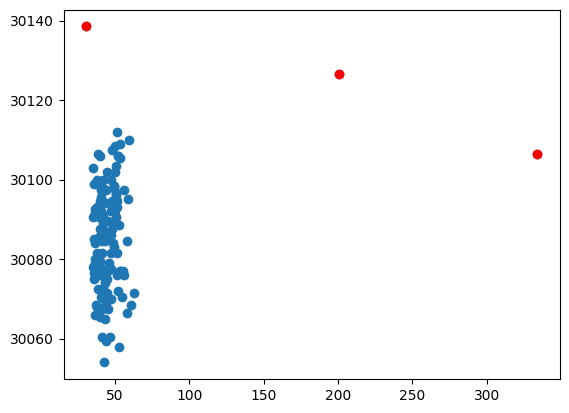

3 points were removed


[2933, 2999, 2664]

In [60]:
o_os = WINDOWS_OS
o_dut = SURFACE_4_PRO
o_test_case = IDLE_CASE
o_profiler = INTEL_POWER_GADGET
#  Win32NT - Surface4Pro - TestCaseIdle - IntelPowerGadget

y_max = 1.1
y_min = 1
x_min = 0
x_max = 0.02

use_x_lim = True
use_y_lim = True

use_x_lim = False
use_y_lim = False


experiments = data[o_dut][o_os][o_test_case][o_profiler]["experiment"].experiments
k = 4
look_back = 6

exp_ids_to_remove = find_outliers(experiments, k, look_back, o_profiler,y_max, y_min, x_min, x_max, use_x_lim, use_y_lim, show_graphs=True)

exp_ids_to_remove

In [61]:
# repository = DataRepository()

In [62]:
# version = dut_version[o_dut][o_os]
# parameters_for_query = (o_dut, o_os, o_test_case, version, o_profiler)
# parameters_for_insert = (k, look_back, o_dut, o_os, o_test_case, version, o_profiler)

# # repository.parameters_exists(parameters_for_query, repository)
# repository.insert_parameters(parameters_for_query, parameters_for_insert, repository)
# repository.get_parameters(parameters_for_query, repository)

In [63]:
import os.path

def write_to_path(save_path, file_name, content):
    with open(os.path.join(save_path,file_name), "w") as file1:
        toFile = content
        file1.write(toFile)

In [64]:
type_map = {
    DRAM_TOTAL : "Dram",
    CORE_TOTAL : "Cores"
}

# for measurement_type in [CORE_TOTAL, DRAM_TOTAL]:
#     for t in test_cases:
#         used_test_cases = [t]

#         p25, p75, low_whiskey, high_whiskey, median, names = plot_comparison(measurement_type, data, dynamic_energy, "core total DUT", "joules in a second", "average core energy consumption in joules for DUTs", ylim_max=100, get_dynamic=True, plot_graph=False, used_test_cases=used_test_cases)


#         plots = ""

#         for val in zip(low_whiskey, p25, median, p75, high_whiskey):
#             plots += """
#                     \\addplot+ [boxplot prepared={{
#                     lower whisker={0},
#                     lower quartile={1},
#                     median={2},
#                     upper quartile={3},
#                     upper whisker={4}}},
#                     ] table[row sep=\\\\,y index=0] {{\\\\}};
#                     """.format(val[0], val[1], val[2], val[3], val[4])

#         xlabel = "Average Energy Consumption (Watts)"
#         title = f"{type_map[measurement_type]} - {t}"
#         ytick = str(list(range(1, len(p25)+1))).replace('[', '').replace(']', '')
#         yticklabels = str(names).replace('[', '').replace(']', '').replace('\'', '')
#         caption = f"{type_map[measurement_type]} average dynamic energy consumption for test case {t} for all DUT's and OS's"
#         label = f"{t}_{type_map[measurement_type]}_comparison_avg_watts"

#         tex = """
#         \\begin{{figure}}
#             \\centering
#             \\begin{{tikzpicture}}[]
#                 \pgfplotsset{{%
#                     width=.8\\textwidth,
#                     height=1.3\\textwidth
#                 }}
#                 \\begin{{axis}}[xlabel={{{0}}}, title={{{1}}}, ytick={{{2}}},
#                 yticklabels={{
#                     {3}
#                     }},
#                     xmin=0,xmax=100,
#                     ]
#                 {4}
#                 \\end{{axis}}
#             \\end{{tikzpicture}}
#         \\caption{{{5}}} \label{{fig:{6}}}
#         \\end{{figure}}
#         """

#         save_path = f"C:/Users/Mads Kusk/git/BiksPower/09th-semester-report/tabels/experiment_results/comparison/{type_map[measurement_type]}"
#         Path(save_path).mkdir(parents=True, exist_ok=True)
#         file_name = f"{t}.tex"
#         content = "succ"
#         write_to_path(save_path, file_name, tex.format(xlabel, title, ytick, yticklabels, plots, caption, label))

In [65]:
from pathlib import Path

In [66]:
used_duts = duts
used_test_cases = [FASTA]



In [67]:
[x for x in duts]

['Surface4Pro', 'SurfaceBook', 'PowerKomplett']

In [68]:


line_colors = ["red", "green", "orange", "black", "pink", "blue"]
line_types = ["thick", "dotted", "dashed", "dashdotted"]

color_mapper = {
    INTEL_POWER_GADGET : "thick",
    HARDWARE_MONITOR : "dotted",
    RAPL : "dashed",
    E3 : "dashdotted",
    CLAMP : "dashdotdotted"
}

style_mapper = {
    SURFACE_4_PRO : "red",
    SURFACE_BOOK : "blue",
    "workstation" : "pink"
}

In [70]:


                # get_buckets,
                # is_correct_charge,
                #                 get_buckets,
                # is_correct_temperature,
exp_types = [("Runs since restart", "how long ago the DUT was restarted", "iteration", is_correct_iteration, get_iteration),
            ("Start battery level", "the battey level of the DUT", "charge", is_correct_charge, get_buckets),
            ("Start temperature", "the temperature of the DUT", "temperature", is_correct_temperature, get_buckets)]

for exp_type in exp_types:
    current_label = exp_type[0] #"Runs since restart"
    current_desc = exp_type[1]#"how long ago the DUT was restarted"
    current_name = exp_type[2]#"iteration"
    current_is_correct = exp_type[3]# is_correct_iteration
    current_get = exp_type[4]#get_iteration
    for measurement_type in [CORE_TOTAL, DRAM_TOTAL]:
        for t in test_cases:
            used_test_cases = [t]
            x_lines, y_lines, name_lines = plot_iterations(CORE_TOTAL,
                            current_get,
                            current_is_correct,
                            "iteration",
                            "average joule",
                            "average joule consumption",
                            data,
                            dynamic_energy,
                            # used_duts=used_duts,
                            used_test_cases = used_test_cases, 
                            plot_graph=False
                            )
                # for i in range(1):
                #     print(1)
            plots = ""
            # for i in range(1):
            #     print(i)
            print("suc")
            for z in zip(x_lines, y_lines,name_lines):
                x = [(x[0], x[1]) for x in zip(z[0], z[1])]
                
                for d in duts:
                    if d in z[2]:
                        style = style_mapper[d]
                        break
                for p in profilers:
                    if p in z[2]:
                        color = color_mapper[p]
                
                if "workstation" in z[2]:
                    color = style_mapper["workstation"]

                
                plots += """
                        \\addplot [mark=none, {0}, {1}]  coordinates {{
                        {2}
                        }};
                        \\addlegendentry{{{3}}}
                        """.format(style, color, str(x).replace('[', '').replace(']', '').replace('), (', ')('), z[2])
                        
            x_label = current_label
            y_label = "Average dynamic energy (watt)"
            caption = f"A graph illustrating the energy consumption of {type_map[measurement_type]} for test case {t} with regards to {current_desc}"
            label = f"{t}_{type_map[measurement_type]}"

            tex = """
            \\begin{{figure}}
                \\centering
                \\begin{{tikzpicture}}
                    \\pgfplotsset{{%
                        width=1\\textwidth,
                        height=0.5\\textheight
                    }}
                    \\begin{{axis}}[
                        xlabel={{{0}}},
                        ylabel={{{1}}},
                    ]
                    {2}
                    \\end{{axis}}
                \\end{{tikzpicture}} 
            \\caption{{{3}}} \label{{fig:{4}}}
            \\end{{figure}}
            """

            save_path = f"C:/Users/Mads Kusk/git/BiksPower/09th-semester-report/tabels/experiment_results/graphs/{current_name}/{type_map[measurement_type]}"
            Path(save_path).mkdir(parents=True, exist_ok=True)
            file_name = f"{t}.tex"
            write_to_path(save_path, file_name, tex.format(x_label, y_label, plots, caption, label))

IndentationError: expected an indented block after 'for' statement on line 36 (260507752.py, line 37)